<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 1*

# 📝 Assignment
---

# Decision Trees(결정트리)

## 캐글 인클래스(InClass) Competitions

### 1) EDA를 수행합시다

- [캐글 계정을 만드세요](https://www.kaggle.com/), 공유된 인클래스 대회 url을 통해 이동한 후 대회에 참여하세요.
- H1N1 데이터를 훈련/검증/테스트 셋으로 나누어 준비하세요
- profiling을 사용하여 데이터를 살펴보고, missing value, zeros, cardinarity 등을 확인하여 처리하세요.
- 본인만의 특성공학을 수행하세요.
- **(객관식) H1N1 분류기의 기준모델을 설정하세요. 기준모델의 정확도를 과제 제출폼에 제출하세요.**
    1. 0.24
    2. 0.50
    3. 0.76
    4. 1


In [240]:
!pip install pandas-profiling==2.*
!pip install category_encoders --upgrade

In [241]:
# 로컬에서 파일 업로드
from google.colab import files
uploaded = files.upload()

In [254]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split

target = 'vacc_h1n1_f'

X = pd.read_csv('/content/train.csv')
X_test = pd.read_csv('/content/test.csv')
y = pd.read_csv('/content/train_labels.csv').drop('vacc_seas_f',axis = 1)

In [255]:
# train, val split 
X_train, X_val, y_train, y_val = train_test_split(X,y,train_size = .8,random_state = 2)

X_train.shape, X_val.shape, X_test.shape

((33723, 38), (8431, 38), (28104, 38))

In [256]:
# 기준 모델 설정 
y_train.value_counts(normalize=True) # 기준 모델의 정확도 0.76 - 3번 

vacc_h1n1_f
0              0.762625
1              0.237375
dtype: float64

In [257]:
from pandas_profiling import ProfileReport

profile = ProfileReport(X,minimal=True).to_notebook_iframe()

# high cardinality - state / employment_industry,employment_occupation column도 각각 23, 25 다른 feature에 비해 high cardinality
# missing values - 27 features 
# zeros - 16 features 
# missing values & zeros - 15 features [h1n1_concern:health_worker]

Summarize dataset:   0%|          | 0/46 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# feature engineering 
 
- seasonal flu vaccine와 관련된 feature 삭제 필요.(seasonal flu vaccine를 받았는지 안 받았는지에 대한 target value는 사용 x)
    - features: `doctor_recc_seasonal`, `opinion_seas_vacc_effective`, `opinion_seas_risk`, `opinion_seas_sick_from_vacc`
    - 총 4개의 feature 삭제 필요.

- employment가 들어간 feature도 삭제

- high cardinality 삭제 필요.(high cardinality는 모델에 악영향을 끼칠 수 있다.)
  - [이곳](https://towardsdatascience.com/high-number-of-unique-values-and-tree-based-models-c30167b63edd)을 참조함.
  - 높다고 생각하는 cardinality : `state(51)`, `employment_industry(23)`,`employment_occupation(25)`

- zeros의 의미 파악 필요.
  - zeros warning이 뜬 15개의 feature들의 zeros는 모두 의미가 있다. 따라서 처리해줄 필요가 없다. 
  - binary feature 내부의 결측값은 SimpleImputer를 이용해서 처리

- 새로운 feature 생성 필요.
  - behavioral를 갖고 있는 features를 합해서 새로운 feature 생성[behaviorals]
    - 각 관측치마다 몇 가지의 행동을 하는지 확인 가능
  - h1n1 vaccine & seasonal vaccine 모두 권고받지 않고 chronic_med_condition 없는  건강한 환자 health_people feature 생성 

In [258]:
## feature engineering
from category_encoders import OneHotEncoder

def change(x):
  if int(x) > 0 :
    return 0
  else:
    return 1

def f_engineering(df):
  #drop high cardinality feature - state
  select_columns = df.select_dtypes(include = ['number','object'])
  labels = select_columns.nunique()
  select_features = labels[labels<=30].index.tolist()
  df = df[select_features]

  # behaviorals feature 생성
  behaviorals = [col for col in df.columns if 'behavioral' in col]
  df['behaviorals'] = df[behaviorals].sum(axis = 1)

  # health_people feature 생성 
  healths = ['doctor_recc_h1n1','doctor_recc_seasonal','chronic_med_condition']
  df['healths'] = df[healths].sum(axis = 1)
  df['healths'] = df['healths'].apply(change)

  # # 건강보험이 있는 workers 
  # workers_h_insurances = ['health_insurance','health_worker']
  # df['workers_have_insurances'] = df[workers_h_insurances].sum(axis = 1)
  # df['workers_have_insurances'] = df['workers_have_insurances'].apply(change)

  # seas & employment가 들어 있는 feature 제거 
  dels = [col for col in df.columns if ('employment' in col or 'seas' in col)] # employment와 seas를 가지고 있는 특성을 모두 제거
  df.drop(columns=dels, inplace=True)

  

  return df 

X_train = f_engineering(X_train)
X_val = f_engineering(X_val)
X_test = f_engineering(X_test)

### 2) 모델 개발
- 결정트리를 학습시킵니다. 하이퍼파라미터를 수정하여 성능을 높여보세요. 과적합을 주의하세요!
- 검증세트 스코어를 확인하세요.(평가지표는 F1-score입니다, 수식은 캐글 Overview-Evaluation 페이지를 확인해 주세요. 평가지표에 대한 내용은 다음에 자세히 배우고 활용할 것입니다 지금은 스코어를 올리기 위한 노력을 전혀 기울이지 말고 결정트리의 개념과 코드이해, 사용에 집중하세요!)
- 특성중요도를 그래프로 나타내 보세요
- **검증세트의 F1-score를 과제 제출폼에 제출하세요. (0.5 이상 통과)**

In [259]:
# training model

from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=1, criterion='entropy')
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train)) 
print('검증 정확도: ', pipe.score(X_val, y_val)) # 과적합
print('\nF1-Score for valid :', f1_score(y_val, pipe.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.9919935948759008
검증 정확도:  0.7466492705491637

F1-Score for valid : 0.49167063303188957


In [260]:
# hyper parameter 조절

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(strategy = 'most_frequent'), 
    DecisionTreeClassifier(random_state=1,max_depth=3)
)

pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train)) 
print('검증 정확도: ', pipe.score(X_val, y_val)) # 과적합
print('\nF1-Score for valid :', f1_score(y_val, pipe.predict(X_val)))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.801322539513092
검증 정확도:  0.797888743921243

F1-Score for valid : 0.5765407554671967


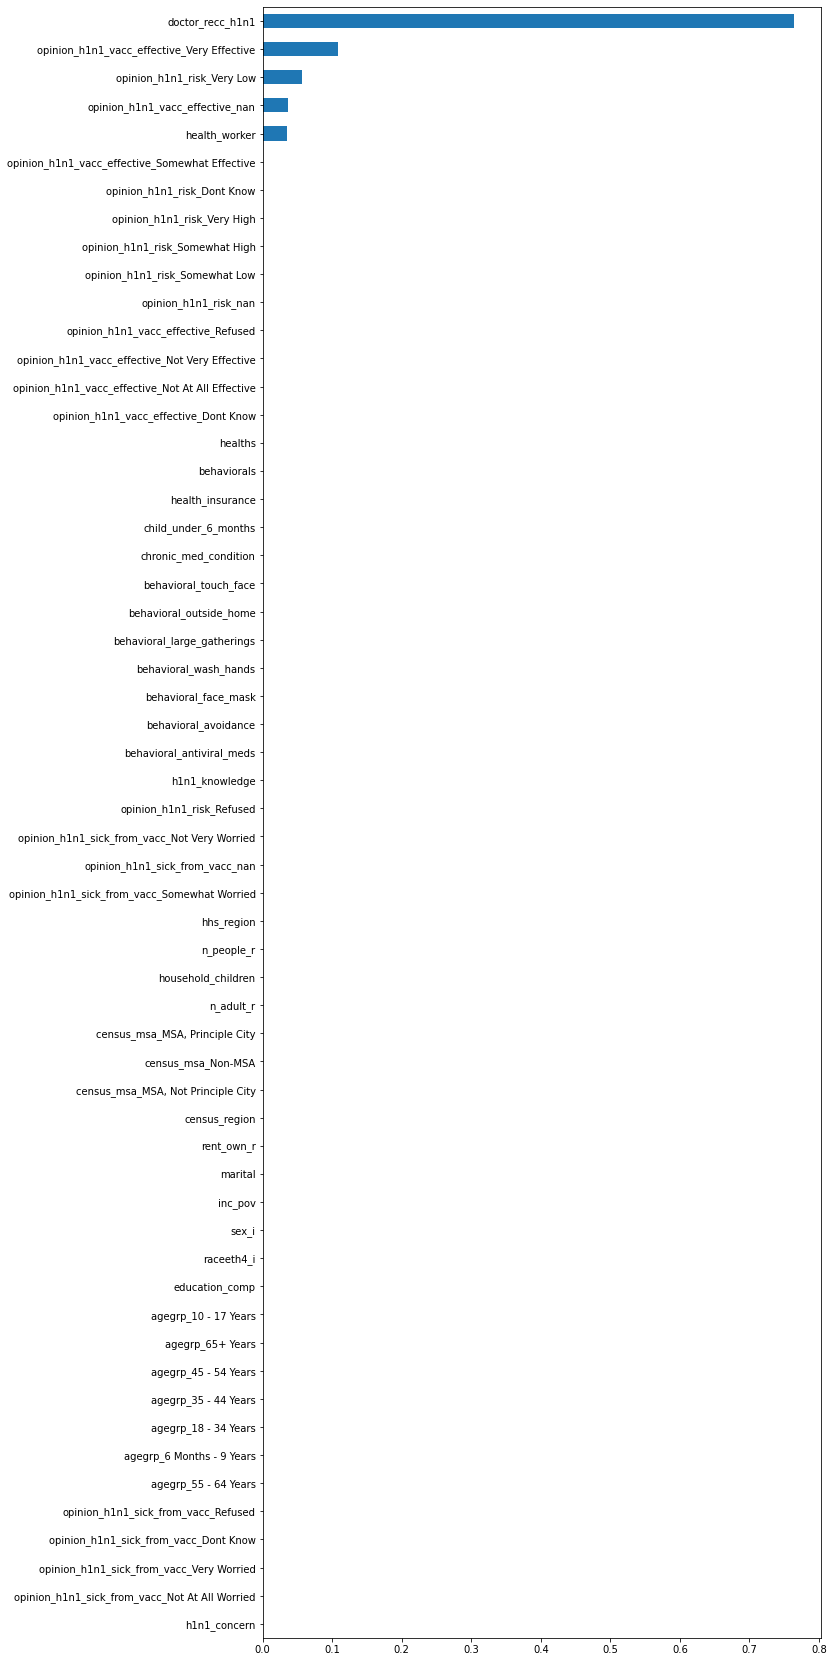

In [261]:
model_dt = pipe.named_steps['decisiontreeclassifier']
enc = pipe.named_steps['onehotencoder']

plt.figure(figsize=(10,30))

encoded_columns = enc.transform(X_val).columns
pd.Series(model_dt.feature_importances_,encoded_columns).sort_values().plot.barh()

### 3) 캐글 대회 참여

- 테스트셋에 대한 예측 결과를 캐글에 제출 하세요.(스코어가 많이 낮게 나와도 결정트리를 잘 이해하고 결과를 내었다면 충분합니다!)
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**
 

In [262]:
y_pred = pipe.predict(X_test)
y_pred.shape

(28104,)

In [263]:
my_submission = pd.DataFrame({
    'Id' : range(0, len(y_pred)),
    'vacc_h1n1_f' : y_pred})
my_submission

,Id,vacc_h1n1_f
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
28099,28099,0
28100,28100,0
28101,28101,0
28102,28102,0


In [265]:
my_submission.to_csv('my_submission.csv', index=False)
# my score : 0.55869

## 🔥 도전과제

### 4) 다른 종류의 imputer를 사용하고 특성-타겟 관계 그래프를 나타내 보세요.
- 다른 종류의 imputer를 사용해 보세요([scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html))
- seaborn plots 사용하여 관심있는 특성들과 target간의 관계를 그래프로 나타내 보세요.
- [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html)
- [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html)

In [ ]:
### 이곳에서 과제를 진행해 주세요 ###